In [1]:
%load_ext autoreload
%autoreload 2

In [57]:
import matplotlib.pyplot as plt

In [10]:
import os
from types import SimpleNamespace

import numpy as np
import pandas as pd
import torch
import xarray as xr
from dask.cache import Cache

from PatchTST_self_supervised.src.callback.patch_mask import PatchCB, ObservationMaskCB
from PatchTST_self_supervised.src.callback.tracking import SaveModelCB
from PatchTST_self_supervised.src.callback.transforms import RevInCB
from PatchTST_self_supervised.src.learner import Learner, transfer_weights
from SeasonTST.dataset import SeasonTST_Dataset
from SeasonTST.utils import find_lr, get_dls, get_model, load_data
from PatchTST_self_supervised.src.metrics import mse, mae


#
# SETUP
#

# Set up Dask's cache. Will reduce repeat reads from zarr and speed up data loading
cache = Cache(1e10)  # 10gb cache
cache.register()

import logging
import datetime

logger = logging.getLogger(__name__)
logging.basicConfig(
    format="%(asctime)s %(levelname)s %(module)s - %(funcName)s: %(message)s",
    datefmt="%m/%d/%Y %I:%M:%S %p",
    filename=f'logs/{datetime.datetime.now().strftime("%Y_%m_%d_%I_%M")}_evaluation.log',
    encoding="utf-8",
    level=logging.DEBUG,
)


#
#  FUNCTIONS
#



def get_learner(args, dls, lr, model):
    """
    Learner set-up

    TRAINING
    - Input is [bs, seq_len, n_vars]
    - Before forward pass:
        - RevInCB normalized inputs
        - ObservationMaskCB masks random observations with fill value
        - PatchCB reshaped to [bs, num_patches, n_vars, patch_len]
    - Forward pass in: [bs, num_patches, n_vars, patch_len]; out: [bs, pred_len, n_vars]
    - After forward pass
        - RevInCB denormalized outputs
        - ObservationMaskCB custom loss function on outputs for just the masked values
        - Loss is therefore mean squared difference on denormalized masked values.
        - Will give more weight to variables with larger numerical range
    """

    # get loss
    loss_func = torch.nn.MSELoss(reduction="mean")
    # get callbacks
    cbs = [RevInCB(dls.vars, denorm=True)] if args.revin else []
    cbs += [
        # ObservationMaskCB(mask_ratio=0.2, mask_value=-99),
        PatchCB(patch_len=args.patch_len, stride=args.stride),
        SaveModelCB(
            monitor="valid_loss", fname=args.save_finetuned_model, path=args.save_path
        ),
    ]
    # define learner
    learner = Learner(dls, model, loss_func, lr=lr, cbs=cbs, metrics=[mse])
    return learner


def save_recorders(learner, args):
    train_loss = learner.recorder["train_loss"]
    valid_loss = learner.recorder["valid_loss"]
    df = pd.DataFrame(data={"train_loss": train_loss, "valid_loss": valid_loss})
    df.to_csv(
        args.save_path + args.save_finetuned_model + "_losses.csv",
        float_format="%.6f",
        index=False,
    )


def test_func(weight_path, learner, args, dls):

    out = learner.test(
        dls.test, weight_path=weight_path, scores=[mse, mae]
    )  # out: a list of [pred, targ, score]
    print("score:", out[2])
    # save results
    pd.DataFrame(np.array(out[2]).reshape(1, -1), columns=["mse", "mae"]).to_csv(
        args.save_path + args.save_finetuned_model + "_acc.csv",
        float_format="%.6f",
        index=False,
    )
    return out


def load_config():

    # Config parameters
    # TODO maybe load from a JSON with a model key?
    config = {
        "c_in": 5,  # number of variables
        "sequence_length": 36,
        "prediction_length": 2,  # Sets both the dimension of y from the dataloader as well as the prediction head size
        "patch_len": 4,  # Length of the patch
        "stride": 4,  # Minimum non-overlap between patchs. If equal to patch_len , patches will not overlap
        "revin": 0,  # reversible instance normalization
        "mask_ratio": 0.4,  # masking ratio for the input
        "lr": 1e-3,
        "batch_size": 128,
        "drop_last": False,  # Whether to drop the last observation that don't make a full batch
        "num_workers": 6,
        "prefetch_factor": 3,
        "n_epochs_pretrain": 1,  # number of pre-training epochs,
        "freeze_epochs": 0,
        "n_epochs_finetune": 250,
        "pretrained_model_id": 2500,  # id of the saved pretrained model
        "save_finetuned_model": "./finetuned_d128",
        "save_path": "saved_models" + "/masked_patchtst/",
    }
    config_obj = SimpleNamespace(**config)

    save_pretrained_model = (
        "patchtst_pretrained_cw"
        + str(config_obj.sequence_length)
        + "_patch"
        + str(config_obj.patch_len)
        + "_stride"
        + str(config_obj.stride)
        + "_epochs-pretrain"
        + str(config_obj.n_epochs_pretrain)
        + "_mask"
        + str(config_obj.mask_ratio)
        + "_model"
        + str(config_obj.pretrained_model_id)
    )
    save_path = "saved_models" + "/masked_patchtst/"
    pretrained_model_path = save_path + save_pretrained_model + ".pth"

    return config_obj, save_path, pretrained_model_path

In [11]:
#
# EVALUATION STEPS
#

In [12]:
data, mask = load_data()

In [13]:
data = data.compute()

In [15]:
mask

<xarray.DataArray (latitude: 2, longitude: 2)>
array([[False, False],
       [False, False]])
Coordinates:
  * latitude   (latitude) float64 -1.025 -1.275
  * longitude  (longitude) float64 9.025 9.275
    time       datetime64[ns] 2024-02-21

In [16]:
config_obj, save_path, pretrained_model_path = load_config()

In [17]:
# Create dataloader
dls = get_dls(config_obj, SeasonTST_Dataset, data, mask)

In [18]:
# Use the finetuned checkpoint
path = save_path + config_obj.save_finetuned_model[2:] + ".pth"
model = get_model(config_obj, headtype="prediction", weights_path=path, exclude_head=False)

number of model params 3176450
weights from saved_models/masked_patchtst/finetuned_d128.pth successfully transferred!



In [132]:
suggested_lr = 0.00020565123083486514 # Irrelevant as no learning in this notebook
learner = get_learner(config_obj, dls, suggested_lr, model)

In [20]:
# Evaluate on test data
# Pass None as weight_path as weights are already in learner.model
pred, targ, score = test_func(None, learner, config_obj, dls)

score: [array(1.6356511, dtype=float32), array(0.99462956, dtype=float32)]


In [133]:
# Var name sorted as in model output
var_names = list(dls.valid.dataset.dataset.data_vars.keys())

In [142]:
# Scaled metrics
rmse = np.sqrt(((pred-targ)**2).mean(axis=(0,1)))
{k: v for k, v in zip(var_names, rmse)}

{'ET0': 0.8274712,
 'LST_SMOOTHED_5KM': 0.8166318,
 'NDVI_SMOOTHED_5KM': 0.99625176,
 'RFH_DEKAD': 2.1371427,
 'SOIL_MOIST': 1.1255051}

In [140]:
# Unscale predictions and targets
u_pred = pred.copy()
u_targ = targ.copy()
for v in range(u_pred.shape[-1]):
    u_pred[:,:,v] = u_pred[:,:,v]*dls.valid.dataset.scaling_factors['std'][var_names[v]] + dls.valid.dataset.scaling_factors['mean'][var_names[v]] 
    u_targ[:,:,v] = u_targ[:,:,v]*dls.valid.dataset.scaling_factors['std'][var_names[v]] + dls.valid.dataset.scaling_factors['mean'][var_names[v]] 

In [144]:
# Unscaled metrics
rmse = np.sqrt(((u_pred-u_targ)**2).mean(axis=(0,1)))
{k: v for k, v in zip(var_names, rmse)}

{'ET0': 1.9098042,
 'LST_SMOOTHED_5KM': 7.892746,
 'NDVI_SMOOTHED_5KM': 0.26191458,
 'RFH_DEKAD': 63.002987,
 'SOIL_MOIST': 0.15036753}

In [150]:
# Compare with std
dls.valid.dataset.scaling_factors['std']

{'ET0': 2.308,
 'LST_SMOOTHED_5KM': 9.665,
 'NDVI_SMOOTHED_5KM': 0.2629,
 'RFH_DEKAD': 29.48,
 'SOIL_MOIST': 0.1336}

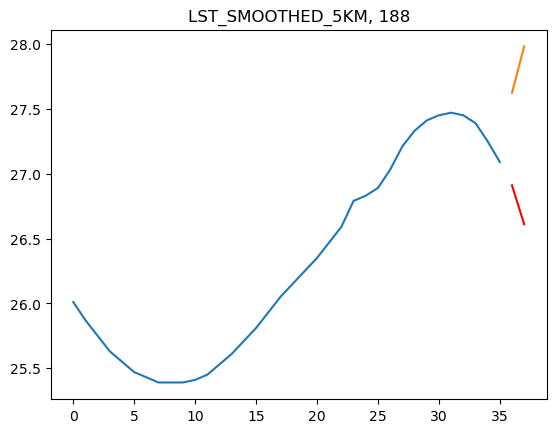

In [149]:
# Plot
v = 1 # index of variable

batch_id = np.random.choice(len(dls.valid.dataset))
var_names = list(dls.valid.dataset.dataset.data_vars.keys())

gt = dls.test.dataset.batch_gen[batch_id].get(var_names[v]).isel(latitude=0, longitude=0).values[:36]
gtp =  np.hstack([np.ones(36)*np.nan, dls.test.dataset.batch_gen[batch_id].get(var_names[v]).isel(latitude=0, longitude=0).values[36:]
])
p = np.hstack([np.ones(36)*np.nan, u_pred[batch_id,:,v]])

plt.plot(gt)
plt.plot(gtp, color='red', label='gt')
plt.plot(p)
plt.title(f"{var_names[v]}, {batch_id}")
plt.show()
